### This notebook plots the vector field for Fig1F, adapted from the code in "Ronghui Zhu et al., Synthetic multistability in mammalian cells. Science 375, eabg9765 (2022). DOI:10.1126/science.abg9765"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from intersect import intersection
from numpy.random import rand
import scipy
from numpy.random import rand
from scipy.integrate import odeint

# Configure plot settings for publication-quality figures
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = "Times New Roman"

In [12]:
def plot_flow_field(ax, duv_dt, u_range, v_range, p, density=1000,
                    sep_fun=None, figscale=1, display_nullcline=True):
    """
    Plots the flow field with line thickness proportional to speed.
    Plots the nullclines
    Plots the stable and unstable fixed points
    Plots the separatrices (optional)
    """
    # for calculating separatrix in the end
    t = np.linspace(0,50,51)
    
    ### First calculate and plot the flow field (phase portrait)
    # set up u,v space
    u = np.linspace(u_range[0], u_range[1], density)
    v = np.linspace(v_range[0], v_range[1], density)

    u_vel = np.zeros((len(u), len(v)))
    v_vel = np.zeros((len(u), len(v)))
    uu, vv = np.meshgrid(u, v)

    # calculate velocity field
    u_vel, v_vel = duv_dt([uu, vv], t, p)
    
    # compute speed
    speed = np.sqrt(u_vel**2 + v_vel**2)

    # make linewidths proportional to speed, with minimal line width of 0.5 and max of 5
    lw = 0.5 + 4.5 * speed / speed.max()
    
    # make stream plot
    s1 = ax.streamplot(uu, vv, u_vel, v_vel, linewidth=lw*figscale, arrowsize=1.5*figscale,
                       density=1, color='grey', zorder=1)
    
    ### Then calculate and plot the nullclines
    # plot nullclines
    if display_nullcline==True:
        c1 = ax.contour(uu, vv, u_vel, 0, colors=sns.color_palette("pastel")[1], linewidths=3*figscale, linestyles='-.', zorder=2)
        c1_label, _ = c1.legend_elements()
        c2 = ax.contour(uu, vv, v_vel, 0, colors=sns.color_palette("pastel")[3], linewidths=3*figscale, linestyles='-.', zorder=2)
        c2_label, _ = c2.legend_elements()
    else:
        c1 = ax.contour(uu, vv, u_vel, 0, colors=sns.color_palette()[1],
                        linewidths=3*figscale, alpha=0)
        c1_label, _ = c1.legend_elements()
        c2 = ax.contour(uu, vv, v_vel, 0, colors=sns.color_palette()[3],
                        linewidths=3*figscale, alpha=0)
        c2_label, _ = c2.legend_elements()
    
    # get nullclines
    if len(c1.allsegs[1])==1:
        Anull = c1.allsegs[1][0]
    else:
        # concatenate all A nullcline segments
        Anull = c1.allsegs[1][0]
        for i in range(len(c1.allsegs[1])-1):
            Anull = np.concatenate((Anull, c1.allsegs[1][i+1]))
        Anull = Anull[np.argsort(Anull[:,0])]
    
    if len(c2.allsegs[1])==1:
        Bnull = c2.allsegs[1][0]
    else:
        # concatenate all B nullcline segments
        Bnull = c2.allsegs[1][0]
        for i in range(len(c2.allsegs[1])-1):
            Bnull = np.concatenate((Bnull, c2.allsegs[1][i+1]))
        Bnull = Bnull[np.argsort(Bnull[:,1])]

    ### Calculate and plot the fixed points
    
    # find fixed points
    x, y = intersection(Anull[:,0], Anull[:,1], Bnull[:,0], Bnull[:,1])
    stable_fp = []
    unstable_fp = []
    # for each fixed point, use the surrounding 4 points to determine the stability
    for i in range(len(x)):
        if stability(x[i], y[i], p)==1:
            stable_fp.append([x[i], y[i]])
        else:
            unstable_fp.append([x[i], y[i]])
    
   
    # plot stable fixed points
    c3 = ax.scatter(np.array(stable_fp)[:,0], np.array(stable_fp)[:,1], zorder=5,
                     c='black', s=500*figscale, edgecolors='black', linewidth=2*figscale)
    sep = []
    # plot unstable fixed points
    if len(unstable_fp)>0:
#         c4 = ax.scatter(np.array(unstable_fp)[:,0], np.array(unstable_fp)[:,1], zorder=4,
#                      c='white', s=1000*figscale, edgecolors='black', linewidth=2*figscale)
        c4 = ax.scatter(np.array(unstable_fp)[2,0], np.array(unstable_fp)[2,1], zorder=4,
                     c='white', s=500*figscale, edgecolors='black', linewidth=2*figscale)    
    
    
        ### Calculate and plot the separatrices
        if sep_fun!=None:
            # calculate the smallest stepsize between adjacent phase portrait points
            stepsize = u[1] - u[0]
            # calculate and plot the seperatrices
            for i in range(len(unstable_fp)):
                sep.append(sep_fun(unstable_fp[i][0], unstable_fp[i][1],
                                   duv_dt, p, stepsize, u_range[1], v_range[1]))
            
            for i in range(len(sep)):   
                c5 = ax.plot(sep[i][:,0], sep[i][:,1], '--', linewidth=3*figscale, color=sns.color_palette()[2], zorder=3)
            
            legend = ax.legend((c1_label[0], c2_label[0], c3, c4, c5[0]),
                               ('Nullcline dA/dt = 0','Nullcline dB/dt = 0', 'Stable fixed point', 'Unstable fixed point', 'Separatrix'),
                               fontsize=12*figscale,frameon=True,framealpha=1,loc='upper right',markerscale=1)
        else:
            legend = ax.legend((c1_label[0], c2_label[0], c3, c4),
                               ('Nullcline dA/dt = 0','Nullcline dB/dt = 0', 'Stable fixed point', 'Unstable fixed point'),
                               fontsize=12*figscale,frameon=True,framealpha=1,loc='upper right',markerscale=1)
            
    elif len(unstable_fp)==0:
        legend = ax.legend((c1_label[0], c2_label[0], c3),
                           ('Nullcline dA/dt = 0','Nullcline dB/dt = 0', 'Stable fixed point'),
                           fontsize=12*figscale,frameon=True,framealpha=1,loc='upper right',markerscale=1)
    
    contour_legends = legend.legendHandles[:2]
    for legend_obj in contour_legends:
        legend_obj.set_linewidth(3.0*figscale)
        
    return ax, sep, stable_fp

In [2]:
def stability(x0, y0, p):
    # x0, y0 = fixed point coord
    # Calculate the stability of fixed point based on eigenvalue of jacobian matrix
    jmat = jacobian(x0, y0, p)
    eig = np.linalg.eigvals(jmat)
    return (np.real(eig)<0).all()

def jacobian(x0, y0, p):
    # Calculate the jacobian matrix
    # Fixed point = (x0, y0)
    # p = parameters
    jmat = np.zeros([2,2])
   
    jmat[0,0] = -p.Gamma_A
    jmat[0,1] = p.Beta_A*p.I*derivative_hill(y0, p.n_BA, p.K_BA)
    jmat[1,0] = -p.Beta_B*(y0**p.n_BB/(y0**p.n_BB+p.K_BB**p.n_BB))*derivative_hill(x0, p.n_AB, p.K_AB)
    jmat[1,1] = -p.Gamma_B + p.Beta_B*(p.K_AB**p.n_AB/(x0**p.n_AB+p.K_AB**p.n_AB))*derivative_hill(y0, p.n_BB, p.K_BB)
    return jmat

def derivative_hill(x, n, k):
    # Calculate the derivative of Hill function
    dx = n*(k**n)*(x**(n-1))/(k**n + x**n)**2
    return dx

In [3]:
def df_dt(y, t, p):
    """
    ODE system for A and B dynamics
    """
    A, B = y
    Jx = ((-p.Gamma_A*A + p.Beta_A*p.I*(B**p.n_BA/(B**p.n_BA+p.K_BA**p.n_BA))))
    Jy = ((-p.Gamma_B*B + p.Beta_B*(p.K_AB**p.n_AB/(A**p.n_AB+p.K_AB**p.n_AB))*(B**p.n_BB/(B**p.n_BB+p.K_BB**p.n_BB))))
    return [Jx, Jy]

In [6]:
class BSParams(object):
    """
    Parameter container for bistable system
    """
    def __init__(self, **kwargs):
        # Dimensionless parameters
        self.Gamma_A = 1 
        self.Gamma_B = 1  
        self.Beta_A = 1
        self.Beta_B = 2
        self.n_BA = 2
        self.n_AB = 2
        self.n_BB = 4
        self.K_BA = 50
        self.K_AB = 1
        self.K_BB = 0.9
        self.I = 1
        
        # Put in params that were specified in input
        for entry in kwargs:
            setattr(self, entry, kwargs[entry])

### Plot the vector field

C:\Users\Acer\AppData\Local\Temp\ipykernel_12468\608466328.py:116: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  c5 = ax.scatter(cells_low[:, 0], cells_low[:, 1],
C:\Users\Acer\AppData\Local\Temp\ipykernel_12468\608466328.py:120: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  c6 = ax.scatter(cells_high[:, 0], cells_high[:, 1],


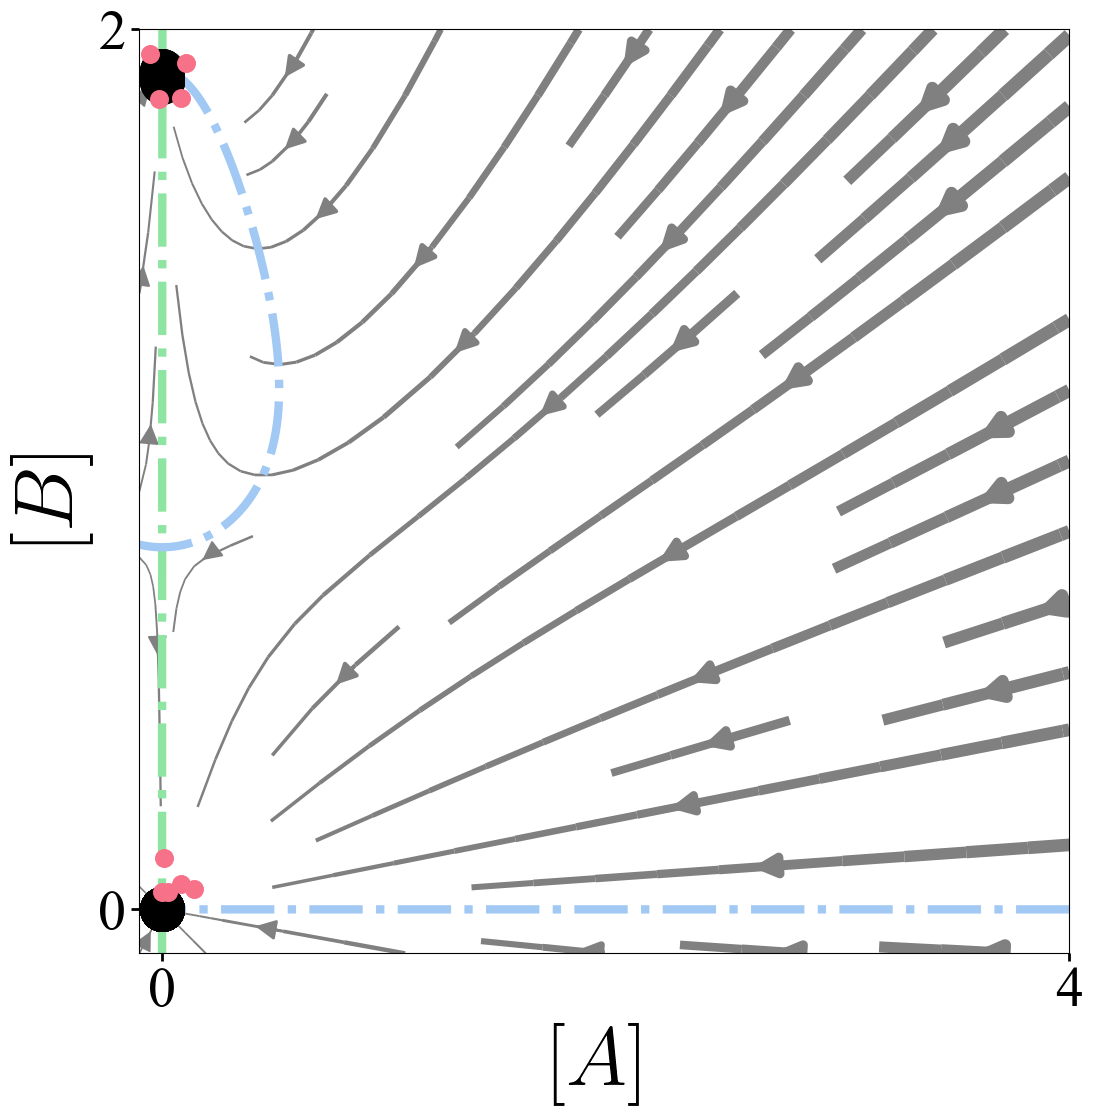

In [13]:
np.random.seed(495)
# Set system parameters
p = BSParams()
p.I = 1  # Input signal: For high input I = 5000; For Low input I = 1 
rangescale = 2.5  # Axis scaling factor
A_range = [-0.1, 4]  # Concentration range for A
B_range = [-0.1, 2]  # Concentration range for B
figscale = 2  # Figure scaling factor
tickint = 10  # Tick interval (unused in final plot)
savedir = None  # Save directory (None for no saving)
density = 500  # Grid density for vector field

# Initialize figure with specified dimensions
fig, ax = plt.subplots(figsize=(6*figscale, 6*figscale))
ax.set_xlim(A_range)
ax.set_ylim(B_range)

#%% Phase Portrait Calculation
# Generate time array for ODE solver
t = np.linspace(0, 50, 51)

# Create grid space for A and B concentrations
u = np.linspace(A_range[0], A_range[1], density)  # A-axis grid
v = np.linspace(B_range[0], B_range[1], density)  # B-axis grid

# Initialize velocity matrices
u_vel = np.zeros((len(u), len(v)))
v_vel = np.zeros((len(u), len(v)))
uu, vv = np.meshgrid(u, v)  # Create 2D grid

# Calculate velocity field using ODE equations
u_vel, v_vel = df_dt([uu, vv], t, p)

# Compute speed magnitude for linewidth scaling
speed = np.sqrt(u_vel**2 + v_vel**2)

# Normalize linewidth between 0.5 and 5 based on speed
lw = 0.5 + 4.5 * speed / speed.max()

# Generate stream plot with velocity field
s1 = ax.streamplot(uu, vv, u_vel, v_vel, 
                   linewidth=lw*figscale, 
                   arrowsize=1.5*figscale,
                   density=0.5, 
                   color='grey', 
                   zorder=1)

#%% Nullcline Calculation and Plotting
# Plot A-nullcline (dA/dt = 0)
c1 = ax.contour(uu, vv, u_vel, 0, 
                colors=sns.color_palette("pastel")[2], 
                linewidths=3*figscale, 
                linestyles='-.', 
                zorder=2)
c1_label, _ = c1.legend_elements()

# Plot B-nullcline (dB/dt = 0)
c2 = ax.contour(uu, vv, v_vel, 0, 
                colors=sns.color_palette("pastel")[0], 
                linewidths=3*figscale, 
                linestyles='-.', 
                zorder=2)
c2_label, _ = c2.legend_elements()

# Process A-nullcline coordinates
if len(c1.allsegs[1]) == 1:
    Anull = c1.allsegs[1][0]
else:
    # Concatenate multiple nullcline segments
    Anull = c1.allsegs[1][0]
    for i in range(len(c1.allsegs[1])-1):
        Anull = np.concatenate((Anull, c1.allsegs[1][i+1]))
    Anull = Anull[np.argsort(Anull[:,0])]  # Sort by A-values

# Process B-nullcline coordinates
if len(c2.allsegs[1]) == 1:
    Bnull = c2.allsegs[1][0]
else:
    # Concatenate multiple nullcline segments
    Bnull = c2.allsegs[1][0]
    for i in range(len(c2.allsegs[1])-1):
        Bnull = np.concatenate((Bnull, c2.allsegs[1][i+1]))
    Bnull = Bnull[np.argsort(Bnull[:,1])]  # Sort by B-values

#%% Fixed Point Analysis
# Find intersections of nullclines (fixed points)
x, y = intersection(Anull[:,0], Anull[:,1], Bnull[:,0], Bnull[:,1])

# Classify fixed points by stability
stable_fp = []
unstable_fp = []
for i in range(len(x)):
    if stability(x[i], y[i], p) == 1:
        stable_fp.append([x[i], y[i]])
    else:
        unstable_fp.append([x[i], y[i]])

# Plot stable fixed points
c3 = ax.scatter(np.array(stable_fp)[:,0], np.array(stable_fp)[:,1], 
                zorder=5, c='black', 
                s=400*figscale, 
                edgecolors='black', 
                linewidth=2*figscale)

#%% Simulated Cell States
N_cells = 5  # Number of cells per state
mean_low = [0, 0]  # Low state mean
mean_high = [0.05, 1.9]  # High state mean
cov = [[0.005, 0], [0, 0.005]]  # Covariance matrix

# Generate cell positions using normal distribution
cells_low = np.random.multivariate_normal(mean_low, cov, N_cells)
cells_high = np.random.multivariate_normal(mean_high, cov, N_cells)

# Plot cell positions
c5 = ax.scatter(cells_low[:, 0], cells_low[:, 1],  
                c=sns.color_palette("husl")[0], 
                s=80*figscale, 
                zorder=6)
c6 = ax.scatter(cells_high[:, 0], cells_high[:, 1], 
                c=sns.color_palette("husl")[0], 
                s=80*figscale, 
                zorder=6)

# Trajectory Simulation
# Set initial conditions
y0 = [0, 1.9]  # Initial state [A(0), B(0)]

# Create time vector for simulation
t = np.linspace(0, 20, 1001)  # 0 to 20 time units with 1001 points

# Solve ODE system
sol = odeint(df_dt, y0, t, args=(p,))

# Plot trajectory
c7, = ax.plot(sol[:, 0], sol[:, 1], 
              color=sns.color_palette("husl")[0], 
              linewidth=3*figscale)    
c8, = ax.plot(sol[:, 0], sol[:, 1], '--', 
              color=sns.color_palette("husl")[0], 
              linewidth=2*figscale)

#%% Figure Formatting
# Configure axis ticks and labels
ax.set_xticks(np.linspace(0, 4, 2))
ax.set_yticks(np.linspace(0, 2, 2))
ax.tick_params(axis='both', 
               labelsize=20*figscale, 
               length=6, 
               width=2)

# Set axis labels with LaTeX formatting
ax.set_xlabel('$[A]$', usetex=True, fontsize=30*figscale)
ax.set_ylabel('$[B]$', usetex=True, fontsize=30*figscale)

# Save figure
# fig.savefig(f'velocity_I_{p.I}', dpi=300)

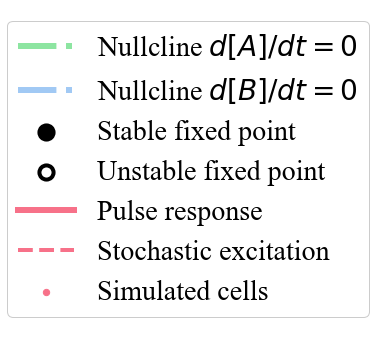

In [249]:
# Plot the legend
figsize = (6, 6)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes
ax_leg.legend((c1_label[0], c2_label[0], c3, c4, c7, c8, c5),
                       ('Nullcline $d[A]/dt = 0$','Nullcline $d[B]/dt = 0$', 'Stable fixed point', 'Unstable fixed point', 'Pulse response', 'Stochastic excitation','Simulated cells'),
                       fontsize=14*figscale,frameon=True,framealpha=1,loc='upper right',markerscale=0.5)
# ax_leg.legend(*ax.get_legend_handles_labels(), loc='center')
# hide the axes frame and the x/y labels
ax_leg.axis('off')
fig_leg.savefig('legend.png', dpi=300)

### Movie: Stochastic excitation

C:\Users\Acer\AppData\Local\Temp\ipykernel_12468\2143429689.py:113: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dots[i].set_data(trajectories[i][max(0,frame-1), 0],
MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\Acer\AppData\Local\Temp\ipykernel_12468\2143429689.py:113: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dots[i].set_data(trajectories[i][max(0,frame-1), 0],


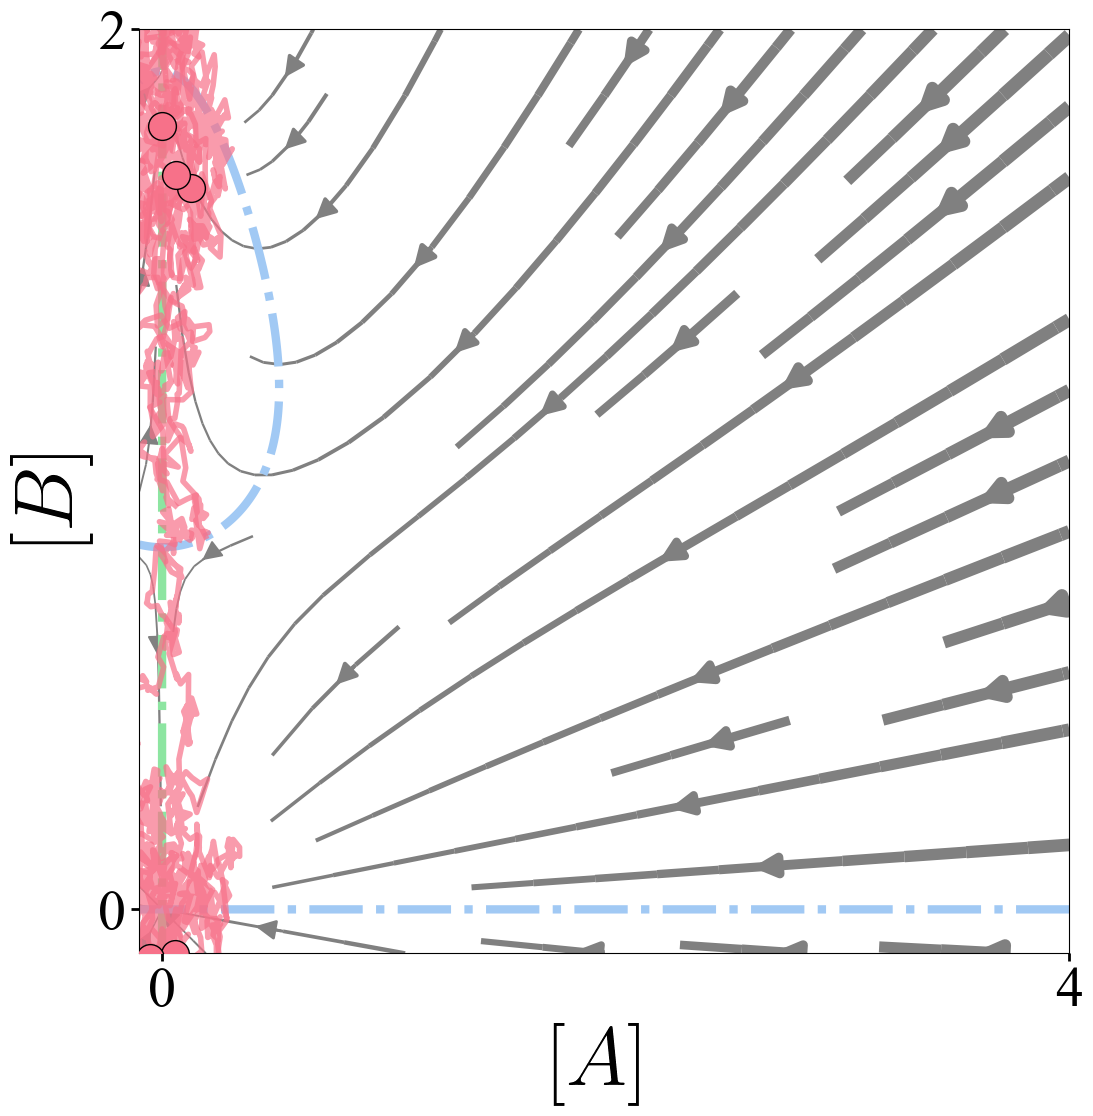

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint

np.random.seed(495)

def sde_system(y, t, p):
    """
    Langevin equation implementation with additive noise
    Returns both deterministic drift and stochastic terms
    """
    A, B = y
    
    # Deterministic part (original ODE terms)
    drift_A = (-p.Gamma_A*A + p.Beta_A*p.I*(B**p.n_BA/(B**p.n_BA + p.K_BA**p.n_BA)))
    drift_B = (-p.Gamma_B*B + p.Beta_B*(p.K_AB**p.n_AB/(A**p.n_AB + p.K_AB**p.n_AB))*(B**p.n_BB/(B**p.n_BB + p.K_BB**p.n_BB)))
    
    # Stochastic part (scaling noise by sqrt(dt) later)
    noise_A = p.sigma * np.random.randn()
    noise_B = p.sigma * np.random.randn()
    
    return np.array([drift_A, drift_B]), np.array([noise_A, noise_B])

def sde_integrate(initial_state, t_span, p):
    """
    Euler-Maruyama integrator for SDE
    Args:
        initial_state: [A0, B0]
        t_span: time points array
        p: parameter object
    Returns:
        trajectory matrix (len(t_span) x 2)
    """
    dt = t_span[1] - t_span[0]
    trajectory = np.zeros((len(t_span), 2))
    trajectory[0] = initial_state
    
    for i in range(1, len(t_span)):
        drift, noise = sde_system(trajectory[i-1], t_span[i-1], p)
        trajectory[i] = trajectory[i-1] + drift*dt + noise*np.sqrt(dt)
        
    return trajectory

#%% System Configuration
p = BSParams(I=1, sigma=0.2)  # Set high input and noise strength
A_range = [-0.1, 4]
B_range = [-0.1, 2]
figscale = 2
density = 500

#%% Initialize Figure
fig, ax = plt.subplots(figsize=(6*figscale, 6*figscale))
ax.set_xlim(A_range)
ax.set_ylim(B_range)

#%% Flow Field (Deterministic Background)
t_phase = np.linspace(0, 50, 51)
u = np.linspace(A_range[0], A_range[1], density)
v = np.linspace(B_range[0], B_range[1], density)
uu, vv = np.meshgrid(u, v)

u_vel, v_vel = df_dt([uu, vv], t_phase, p)
speed = np.sqrt(u_vel**2 + v_vel**2)
lw = 0.5 + 4.5 * speed / speed.max()
ax.streamplot(uu, vv, u_vel, v_vel, 
              linewidth=lw*figscale, 
              arrowsize=1.5*figscale,
              density=0.5, 
              color='grey', 
              zorder=1)

#%% Nullcline Configuration
# A-nullcline (dA/dt = 0)
c1 = ax.contour(uu, vv, u_vel, 0,
               colors=sns.color_palette("pastel")[2],
               linewidths=3*figscale,
               linestyles='-.',
               zorder=2)

# B-nullcline (dB/dt = 0) 
c2 = ax.contour(uu, vv, v_vel, 0,
               colors=sns.color_palette("pastel")[0],
               linewidths=3*figscale,
               linestyles='-.',
               zorder=2)

#%% Cell Dynamics Simulation
cell_color = sns.color_palette("husl")[0]
N_cells = 5
mean_high = [0.05, 0.8]
cov = [[0.005, 0], [0, 0.005]]
cells_high = np.random.multivariate_normal(mean_high, cov, N_cells)

# Time parameters
t_simulation = np.linspace(0, 10, 501)  # 0-10 time units, 501 points

# Generate stochastic trajectories
trajectories = [sde_integrate(cell, t_simulation, p) for cell in cells_high]

#%% Animation Elements
lines = [ax.plot([], [], color=cell_color, lw=2*figscale, alpha=0.7)[0] 
         for _ in range(N_cells)]
dots = [ax.plot([], [], 'o', color=cell_color, markersize=10*figscale,
                markeredgecolor='k', zorder=10)[0] 
        for _ in range(N_cells)]

# Update function with stochastic paths
def update(frame):
    for i in range(N_cells):
        lines[i].set_data(trajectories[i][:frame, 0], trajectories[i][:frame, 1])
        dots[i].set_data(trajectories[i][max(0,frame-1), 0], 
                        trajectories[i][max(0,frame-1), 1])
    return lines + dots

# Final plot formatting
ax.set_xticks(np.linspace(0, 4, 2))
ax.set_yticks(np.linspace(0, 2, 2))
ax.tick_params(axis='both', labelsize=20*figscale, length=6, width=2)
ax.set_xlabel('$[A]$', usetex=True, fontsize=30*figscale)
ax.set_ylabel('$[B]$', usetex=True, fontsize=30*figscale)

# Create and save animation
ani = FuncAnimation(fig, update, frames=len(t_simulation), interval=20, blit=True)
ani.save('stochastic excitation.gif', writer='ffmpeg', fps=30, dpi=100)
plt.show()

### Movie: Pulse response

C:\Users\Acer\AppData\Local\Temp\ipykernel_12468\1228258235.py:115: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dots[i].set_data(trajectories[i][max(0,frame-1), 0],
MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\Acer\AppData\Local\Temp\ipykernel_12468\1228258235.py:115: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  dots[i].set_data(trajectories[i][max(0,frame-1), 0],


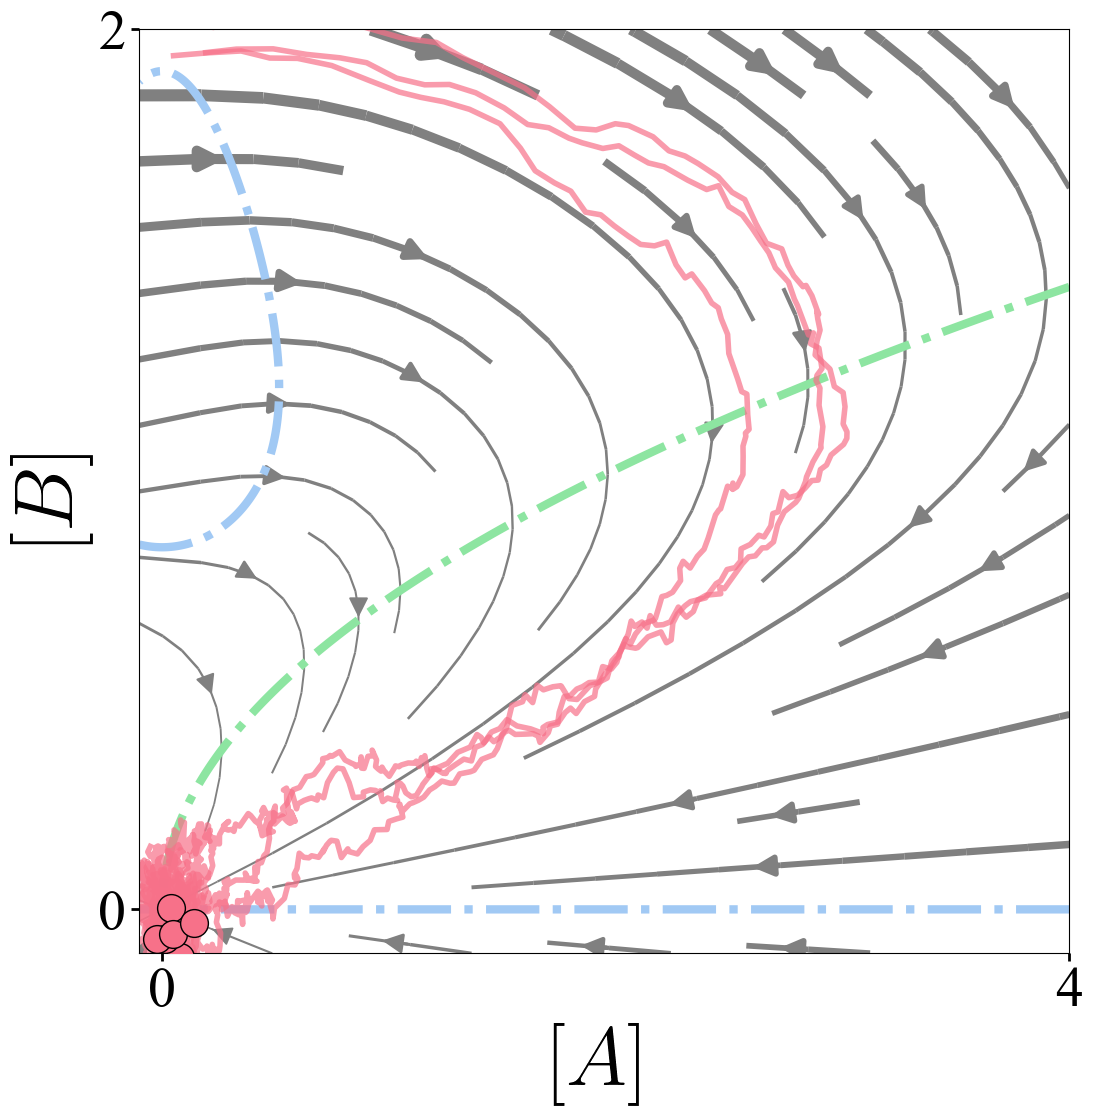

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint

np.random.seed(495)

def sde_system(y, t, p):
    """
    Langevin equation implementation with additive noise
    Returns both deterministic drift and stochastic terms
    """
    A, B = y
    
    # Deterministic part (original ODE terms)
    drift_A = (-p.Gamma_A*A + p.Beta_A*p.I*(B**p.n_BA/(B**p.n_BA + p.K_BA**p.n_BA)))
    drift_B = (-p.Gamma_B*B + p.Beta_B*(p.K_AB**p.n_AB/(A**p.n_AB + p.K_AB**p.n_AB))*(B**p.n_BB/(B**p.n_BB + p.K_BB**p.n_BB)))
    
    # Stochastic part (scaling noise by sqrt(dt) later)
    noise_A = p.sigma * np.random.randn()
    noise_B = p.sigma * np.random.randn()
    
    return np.array([drift_A, drift_B]), np.array([noise_A, noise_B])

def sde_integrate(initial_state, t_span, p):
    """
    Euler-Maruyama integrator for SDE
    Args:
        initial_state: [A0, B0]
        t_span: time points array
        p: parameter object
    Returns:
        trajectory matrix (len(t_span) x 2)
    """
    dt = t_span[1] - t_span[0]
    trajectory = np.zeros((len(t_span), 2))
    trajectory[0] = initial_state
    
    for i in range(1, len(t_span)):
        drift, noise = sde_system(trajectory[i-1], t_span[i-1], p)
        trajectory[i] = trajectory[i-1] + drift*dt + noise*np.sqrt(dt)
        
    return trajectory

#%% System Configuration
p = BSParams(I=5000, sigma=0.1)  # Set high input and noise strength
A_range = [-0.1, 4]
B_range = [-0.1, 2]
figscale = 2
density = 500

#%% Initialize Figure
fig, ax = plt.subplots(figsize=(6*figscale, 6*figscale))
ax.set_xlim(A_range)
ax.set_ylim(B_range)

#%% Flow Field (Deterministic Background)
t_phase = np.linspace(0, 50, 51)
u = np.linspace(A_range[0], A_range[1], density)
v = np.linspace(B_range[0], B_range[1], density)
uu, vv = np.meshgrid(u, v)

u_vel, v_vel = df_dt([uu, vv], t_phase, p)
speed = np.sqrt(u_vel**2 + v_vel**2)
lw = 0.5 + 4.5 * speed / speed.max()
ax.streamplot(uu, vv, u_vel, v_vel, 
              linewidth=lw*figscale, 
              arrowsize=1.5*figscale,
              density=0.5, 
              color='grey', 
              zorder=1)

#%% Nullcline Configuration
# A-nullcline (dA/dt = 0)
c1 = ax.contour(uu, vv, u_vel, 0,
               colors=sns.color_palette("pastel")[2],
               linewidths=3*figscale,
               linestyles='-.',
               zorder=2)

# B-nullcline (dB/dt = 0) 
c2 = ax.contour(uu, vv, v_vel, 0,
               colors=sns.color_palette("pastel")[0],
               linewidths=3*figscale,
               linestyles='-.',
               zorder=2)

#%% Cell Dynamics Simulation
cell_color = sns.color_palette("husl")[0]
N_cells = 6
mean_high = [0.05, 1.9]
mean_low = [0.05, 0.1]
cov = [[0.005, 0], [0, 0.005]]
cells_high = np.random.multivariate_normal(mean_high, cov, int(N_cells/2))
cells_low = np.random.multivariate_normal(mean_low, cov, int(N_cells/2))

# Time parameters
t_simulation = np.linspace(0, 10, 501)  # 0-10 time units, 501 points

# Generate stochastic trajectories
trajectories = [sde_integrate(cell, t_simulation, p) for cell in np.vstack([cells_high, cells_low])]

#%% Animation Elements
lines = [ax.plot([], [], color=cell_color, lw=2*figscale, alpha=0.7)[0] 
         for _ in range(N_cells)]
dots = [ax.plot([], [], 'o', color=cell_color, markersize=10*figscale,
                markeredgecolor='k', zorder=10)[0] 
        for _ in range(N_cells)]

# Update function with stochastic paths
def update(frame):
    for i in range(N_cells):
        lines[i].set_data(trajectories[i][:frame, 0], trajectories[i][:frame, 1])
        dots[i].set_data(trajectories[i][max(0,frame-1), 0], 
                        trajectories[i][max(0,frame-1), 1])
    return lines + dots

# Final plot formatting
ax.set_xticks(np.linspace(0, 4, 2))
ax.set_yticks(np.linspace(0, 2, 2))
ax.tick_params(axis='both', labelsize=20*figscale, length=6, width=2)
ax.set_xlabel('$[A]$', usetex=True, fontsize=30*figscale)
ax.set_ylabel('$[B]$', usetex=True, fontsize=30*figscale)

# Create and save animation
ani = FuncAnimation(fig, update, frames=len(t_simulation), interval=20, blit=True)
ani.save('Pulse response.gif', writer='ffmpeg', fps=30, dpi=100)
plt.show()